# Tarea 4

Cuentas con un set de datos de imágenes en blanco y negro (de 28x28 pixeles) de distintas prendas de vestir (son 10 tipos de prendas en total, mira [aca](https://github.com/zalandoresearch/fashion-mnist)). En esta tarea vas a resolver el problema de crear nuevas imágenes prendas de vestir. Especificamente, la tarea que se te ha encomendado es:

> Elige dos tipos de los 10 tipos de prendas
>>Para cada uno de esos dos tipos, escribe una función que retorne uno de esos dos tipos, y retorne una nueva imagen de ese tipo, obtenida al azar, que no esté ya en el dataset

La solución a trabajar para escribir esta funcion consta de las siguientes partes

### Parte 1: datos, reducción de dimensionalidad

- Prueba dos formas de reducir a 6 dimensiones: PCA y autoencoders. 
- Busca 3 imágenes en el dataset. Para esas tres imágenes, compara visualmente lo que ocurre al (1) graficar la imagen original (hay código para eso más abajo) y (2) tomar el vector de la imagen, codificarlo, decodificarlo y volver a graficar (para pca y autoencoder, recuerda estandarizar y luego des-estandarizar, como hicimos en el notebook de compresión de la semana 9). 
- Sigue afinando tu método de reducción hasta que entregue imágenes que al codificar/decodificar, la imagen nueva resultante todavía guarde alguna semejanza con la realidad. 
- Una vez que estés satisfecho, transforma todo el dataset con tu método de reducción. Al dataset resultante (ahora con 6 dimensiones) le llamaremos **Xreducido**

### Parte 2: clustering y sampling 

- Ejecuta un algoritmo de clustering GMM sobre **Xreducido**, con 10 clústeres. Averigua como obtener las medias y las covarianzas de los 10 clústeres resultantes. 
- Usa *np.random.multivariate_normal(mean_vector,covariance_matrix)*, que se usa para obtener un elemento de la normal multivariada con su vector de media *mean_vector* y matriz de covarianzas *covariance_matrix*, para obtener un sample de cada una de las 10 gaussianas que entrenó tu GMM. Esos samples son elementos que podrían pertenecer a cada uno de los clústeres detectados por tu GMM. 

### Parte 3: análisis  

- Cada sample puede ser graficado como imagen: hay que pasarlo por el decodificador (o la transformada inversa en el caso de PCA). 
- Analiza visualmente dos samples de cada clase
- Analiza visualmente la media de cada cluster identificado por GMM
- Con las visualizaciones de esta parte, responde: ¿qué clústeres parece entregar consistentemente prendas de un tipo en específico? ¿qué prendas son?
- Entrena un clasificador de randomforest con los datos originales. 
- Samplea y decodifica 50 ejemplos de cada cluster identificado por GMM, y entrégaselos al randomforest. Ahora ve los resultados de las predicciones. Vé si son consistentes en el sentido de que predicen que una buena cantidad de los ejemplos de los dos clústeres que identificaste son de una prenda en particular. 

### Detalles académicos

La entrega de esta tarea es el Viernes 8 de Noviembre, a las 20:00, por canvas. 

## Datos

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.decomposition import PCA
import numpy as np


Bajamos el dataset, nos quedamos con 10.000 tuplas (esto es opcional, para que todo cargue más rápido, mientras más tuplas se dejen, mejor deberían ser los resultados)

In [2]:
mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=True)
mnist.keys()

X, y = mnist['data'], mnist['target']
X_sample = X[60000:]
y_sample = y[60000:]
X_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 60000 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 59.8 MB


### Mostrando una foto
Para mostrar las fotos, tenemos que volver a formato de 28x28 píxeles

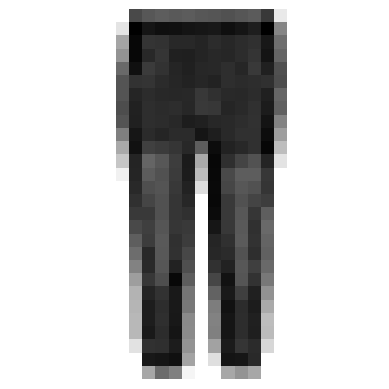

In [ ]:
#sacar la entidad numero 2000 del dataset 

some_garment = X_sample.iloc[3000]
some_garment_image = some_garment.values.reshape(28,28)

plt.imshow(some_garment_image, cmap='binary')
plt.axis('off')
plt.show()

# ACA COMIENZA TU TRABAJO

# Parte 1: reducir dimensionalidad
¡Recuerda estandarizar los datos!

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=23)

In [5]:
# Estanadarizando X_sample

sc = StandardScaler()
X_std = sc.fit_transform(X_sample)
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [6]:
indices = [0, 1, 2]  # Cambia estos índices según tus datos
imagenes_originales = X_std[indices]
# Des-estandarizar para visualizar
imagenes_desestandarizadas = sc.inverse_transform(imagenes_originales)

Autoencoders

In [7]:
num_dimensiones = X_std.shape[1]
encoder = keras.models.Sequential([
    keras.layers.Dense(5, input_shape=[num_dimensiones]),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(num_dimensiones, input_shape=[5]),
])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=0.1))

history = autoencoder.fit(X_std, X_std, epochs=100, validation_data=(X_std, X_std),
                          callbacks=[keras.callbacks.EarlyStopping(patience=10)])

X_encoded = encoder.predict(X_std[indices])

Epoch 1/100


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-22 21:07:47.621638: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


273/313 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 0.9278

2024-10-22 21:07:48.067964: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.
2024-10-22 21:07:48.103154: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9156 - val_loss: 0.6372
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6376 - val_loss: 0.5775
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5498 - val_loss: 0.5249
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5073 - val_loss: 0.5046
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4997 - val_loss: 0.4974
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5026 - val_loss: 0.4946
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5082 - val_loss: 0.4930
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4955 - val_loss: 0.4918
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4977 - val_loss: 0.4912
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4869 - val_loss: 0.4907
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4802 - val_loss: 0.4904
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [8]:
# Codificar y decodificar las imágenes seleccionadas
X_encoded = encoder.predict(X_std[indices]) 
# Decodificar usando el decoder
X_decoded = decoder.predict(X_encoded)  
# Des-estandarizar
imagenes_decodificadas = sc.inverse_transform(X_decoded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


PCA

In [27]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_std)
scaler_pca = StandardScaler()
scaler_pca.fit(X_pca)  # Ajustar el scaler a los datos PCA

# Des-estandarizar las imágenes PCA
imagenes_pca = scaler_pca.inverse_transform(X_pca)

Comparación

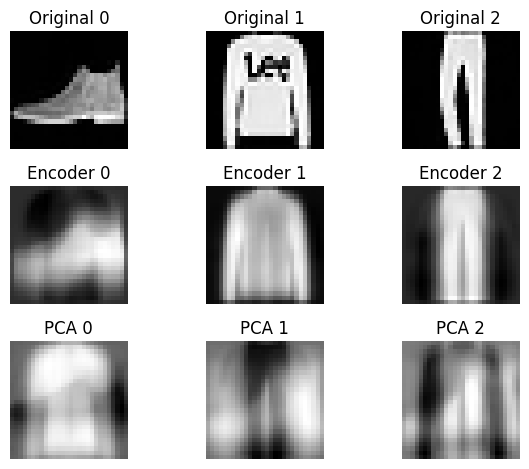

In [28]:
# Imágenes originales
for i in range(len(indices)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(imagenes_desestandarizadas[i].reshape(28, 28), cmap='gray')  # Ajusta según la forma de tus imágenes
    plt.title('Original ' + str(indices[i]))
    plt.axis('off')

# Imágenes decodificadas del autoencoder
for i in range(len(indices)):
    plt.subplot(3, 3, i + 4)
    plt.imshow(imagenes_decodificadas[i].reshape(28, 28), cmap='gray')  # Ajusta según la forma de tus imágenes
    plt.title('Encoder ' + str(indices[i]))
    plt.axis('off')

for i in range(len(indices)):
    plt.subplot(3, 3, i + 7)
    plt.imshow(pca.components_[i].reshape(28, 28), cmap='gray')  # Reshape a 28x28
    plt.title('PCA ' + str(indices[i]))
    plt.axis('off')


plt.tight_layout()
plt.show()

Finalmente: ¿Con qué estrategia para reducir dimensionalidad te quedas? Transforma *X_sample* a *X_reducido*

**Respuesta:** Me quedaría con Encoder, porque PCA las imagenes no se ven correctamente. Encoder se parece pero pixeliado.

In [31]:
import keras
from sklearn.preprocessing import StandardScaler

# Estandarizando X_sample
sc = StandardScaler()
X_std = sc.fit_transform(X_sample)

num_dimensiones = X_std.shape[1]

# Definición del encoder con Dropout
encoder = keras.models.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=[num_dimensiones]),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(5, activation='relu'),
])

# Definición del decoder
decoder = keras.models.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=[5]),
    keras.layers.Dense(num_dimensiones, activation='sigmoid'),
])

# Definición del autoencoder
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01))

# Entrenamiento del autoencoder
history = autoencoder.fit(X_std, X_std, epochs=200, validation_data=(X_std, X_std),
                          callbacks=[keras.callbacks.EarlyStopping(patience=10)])

# Transformación del dataset
X_reducido = encoder.predict(X_std)

Epoch 1/200


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8723 - val_loss: 0.7647
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7862 - val_loss: 0.7546
Epoch 3/200


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7668 - val_loss: 0.7475
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7799 - val_loss: 0.7518
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7713 - val_loss: 0.7408
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7824 - val_loss: 0.7362
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7542 - val_loss: 0.7318
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7612 - val_loss: 0.7317
Epoch 9/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7592 - val_loss: 0.7333
Epoch 10/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7415 - val_loss: 0.7322
Epoch 11/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7665 - val_loss: 0.7270
Epoch 12/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7530 - val_loss: 0.7271
Epoch 13/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7526 - val_loss: 0.7281
Epoch 14/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st

# Parte 2: Sampleo

Hacer fit de un modelo GMM

In [ ]:
from sklearn.mixture import GaussianMixture



Código para samplear de un cluster en particular

# Parte 3: Comparación PCA/Autoencoder en base a samples

Analiza visualmente dos samples de cada clase (toma dos samples de cada clase, decodifica, des-estandariza y grafica como mostramos en la parte de datos)

Analiza visualmente la meda

¿qué clústeres parece entregar consistentemente prendas de un tipo en específico? ¿qué prendas son?

Entrena un clasificador de randomforest con los datos originales. 

Samplea y decodifica 50 ejemplos de cada cluster identificado por GMM, y entrégaselos al randomforest. Ahora ve los resultados de las predicciones. Vé si son consistentes en el sentido de que predicen que una buena cantidad de los ejemplos de los dos clústeres que identificaste son de una prenda en particular. 